# Sentiment Analysis

This notebook intends to build a sentiment classifier (positive, negative) from “Multi-Domain Sentiment Dataset” per each category (“Books”, “DVD”, “Electronics”, “Kitchen”).

### Library imports

In [1]:
pip install nltk

In [2]:
#Scikit-learn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression, SGDClassifier

#Libraries to graph
import matplotlib.pyplot as plt
import seaborn as sns

#NLTK
import nltk
from nltk.corpus import stopwords
import re
import pandas as pd


stemmer = nltk.stem.SnowballStemmer('english')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

### Read and transform the .review's files

Run the python file "PreProcessingSentimentAnalysis.py"

### Creating the training/validation dataframe

In [3]:
def create_df (file_name):
    df = pd.read_csv(file_name, sep=',')
    return df


### Text processing function

In [4]:
def text_processing(text):
    # Step 1: Remove special characters using a regular expression (non-words).
    processed_feature = re.sub(r'\W', ' ', str(text))
    # Step 2: Remove single-character occurrences.
    processed_feature = re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature)
    # Step 3: Remove numbers (very sporadic occurrences in our dataset).
    processed_feature = re.sub(r'[0-9]+', ' ', processed_feature)
    # Step 4: Simplify consecutive spaces to a single space between words.
    processed_feature = re.sub(' +', ' ', processed_feature)
    # Step 5: Convert all text to lowercase.
    processed_feature = processed_feature.lower()
    # Step 6: Apply stemming. It's a way to bring words to a common root, simplifying the vocabulary.
    # This helps to avoid having two different words with the same meaning in our vocabulary.
    processed_feature = " ".join([stemmer.stem(i) for i in processed_feature.split()])

    return processed_feature


Applying the text processing function to each data set

In [5]:
def apply_processing(category)->list:

    #Extracting the unprocessed texts and its labels
    not_processed = category['review'].values
    labels = category['label'].values

    #Creating a list to save the processed texts
    processed = []

    #Processing all the texts
    for t in range(0, len(not_processed)):
        text = text_processing(not_processed[t])
        processed.append(text)

    # Saving the processed texts in the df
    category['processed'] = processed

    #Returning the processeddf
    return category


### Text representation

In this part we must take the processed text and represent it in such way we can operate it correctly. We are going to create a bow (bag of words)

### Vectorizer

We are using the CountVectorizer in order to create the bow

In [6]:
def bow(processed_text:list):

    #Bag of words
    vectorizer = CountVectorizer(max_features=14000, stop_words=stopwords.words('english'))

    #Now we build the vocabulary and also transform our text using our dataset
    text_features = vectorizer.fit_transform(processed_text).toarray()
    print(vectorizer.get_feature_names_out()[0:10])

    return {'features':text_features,
            'vectorizer': vectorizer}

### Training and evaluation

In [7]:
def NB(features, labels):
    x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=0)
    #Naive Bayes
    nb = MultinomialNB()
    #Training the model
    nb.fit(x_train, y_train)

    return {'model': nb,
            'x_train': x_train,
            'y_train': y_train,
            'x_test': x_test,
            'y_test': y_test,}

In [8]:
def evaluation(model, x_test, y_test):

    y_pred = model.predict(x_test)
    print("Evaluating metrics")
    print(classification_report(y_test, y_pred, digits=4))
    cm = confusion_matrix(y_test, y_pred,labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()



## Entire process for each category

### Books

First we create the consolidated file and the dataframe

In [9]:
book_df = create_df('books_consolidated.csv')
#print(book_df.sample(5))

Then we apply the processing function

In [10]:
processed_book_df = apply_processing(book_df)
#print(processed_book_df.sample(5))

Lets check that the processing was done correctly

In [11]:
print("Review 1000 before processing")
print(book_df.loc[1000]['review'])
print("Review 1000 after processing")
print(processed_book_df.loc[1000]['processed'])

Review 1000 before processing
 avid your horrible book wasted use it the entire money.i i lit i read lit i would relationship read a <num> reader and reader suffering fire one i had year old year old gotten horrible horrible horrible lit this world...don't my my one star headache the this book this book this book this book this book mom was horrible friend book horrible star i back avid reader than one life copy rate it rate my mom man book was half on fire and then reading this so lower i could <num> year <num> year than time time half of time spent then book book book book book book and picked possible spent old man up after one one horrible if one less part was was entire less copy to rate my life about the your money.i an avid if the relationship use a headache fire lower than reading a friend picked purposes then got waste your after my friend i old old man and and i world...don't waste book on part about copy in book back book wasted have i time and the world...don't better if it

We are extracting the features using the vectorizer we created previously, and we are also saving that trained vectorizer so that we can reuse it when testing the unlabeled files

In [12]:
book_fv = bow(processed_book_df['processed'].values)
book_features = book_fv['features']
book_vectorizer = book_fv['vectorizer']

['aa' 'aat' 'ab' 'aba' 'abaci' 'aback' 'abandon' 'abb' 'abbasid' 'abbot']


We train the model using Multinomial Naive Bayes

In [13]:
book_labels = processed_book_df['label'].values
book_model = NB(book_features, book_labels)

In [14]:
book_nb = book_model['model']
book_x_train = book_model['x_train']
book_x_test = book_model['x_test']
book_y_train = book_model['y_train']
book_y_test = book_model['y_test']

#### Evaluation with the training data set

Finally we evaluate the model using theese metrics

Evaluating metrics
              precision    recall  f1-score   support

    negative     0.7619    0.8000    0.7805       200
    positive     0.7895    0.7500    0.7692       200

    accuracy                         0.7750       400
   macro avg     0.7757    0.7750    0.7749       400
weighted avg     0.7757    0.7750    0.7749       400



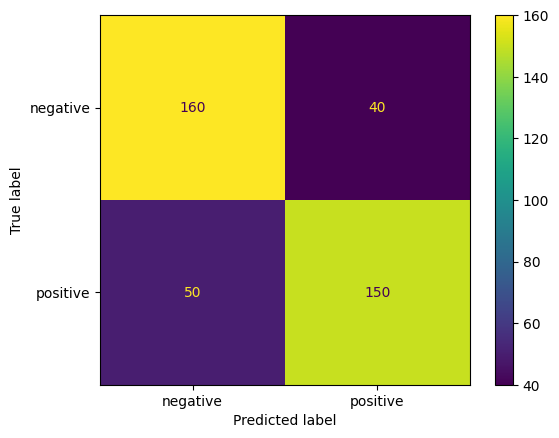

In [15]:
evaluation(book_nb, book_x_test, book_y_test)

#### Evaluating with the unlabeled data set

In [16]:
book_test_df = create_df('books_test.csv')

In [17]:
processed_test_book_df = apply_processing(book_test_df)

In [18]:
test_book_features = book_vectorizer.transform(processed_test_book_df['processed'].values)

Evaluating metrics
              precision    recall  f1-score   support

    negative     0.7415    0.7987    0.7690      2201
    positive     0.7884    0.7292    0.7577      2264

    accuracy                         0.7635      4465
   macro avg     0.7650    0.7640    0.7634      4465
weighted avg     0.7653    0.7635    0.7633      4465



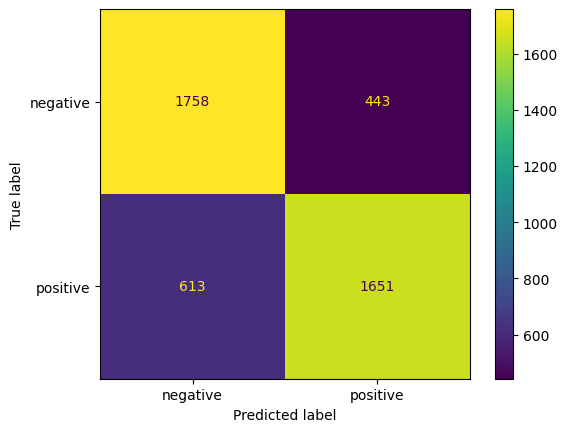

In [19]:
un_book_x_test = test_book_features
un_book_y_test = processed_test_book_df['label'].values

evaluation(book_nb, un_book_x_test, un_book_y_test)

#### Regresion logistica

We are creating a logistic SGD model

In [20]:
logistic_model_SGD = SGDClassifier(loss='log_loss',learning_rate='constant',eta0=0.001 )
logistic_model_SGD.fit(book_x_train, book_y_train)

SGDClassifier(eta0=0.001, learning_rate='constant', loss='log_loss')

In [21]:
print(f'Classes of the dependent variable: {logistic_model_SGD.classes_}')
print('\n')
print('Coefficient Vectors:')
print(logistic_model_SGD.coef_)


Classes of the dependent variable: ['negative' 'positive']


Coefficient Vectors:
[[ 0.00329221  0.          0.00592442 ...  0.01258183 -0.01842824
  -0.0027081 ]]


We are going to use this model to predict the same unlabeled data set to compare the results

Evaluating metrics
              precision    recall  f1-score   support

    negative     0.8024    0.7896    0.7960      2201
    positive     0.7986    0.8110    0.8047      2264

    accuracy                         0.8004      4465
   macro avg     0.8005    0.8003    0.8004      4465
weighted avg     0.8005    0.8004    0.8004      4465



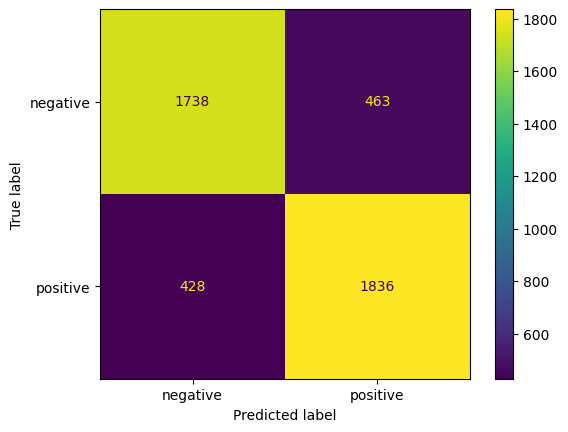

In [22]:
evaluation(logistic_model_SGD, un_book_x_test, un_book_y_test)

### dvds

First we create the consolidated file and the dataframe

In [24]:
dvd_df = create_df('dvd_consolidated.csv')
#print(dvd_df.sample(5))

Then we apply the processing function

In [25]:
processed_dvd_df = apply_processing(dvd_df)
#print(processed_dvd_df.sample(5))

Lets check that the processing was done correctly

In [26]:
print("Review 1000 before processing")
print(dvd_df.loc[1000]['review'])
print("Review 1000 after processing")
print(processed_dvd_df.loc[1000]['processed'])

Review 1000 before processing
 i i i i movie could movies i in only minutes and boring it only <num> me decent run out before was walked theater and long love a ever even was at anything you the theater might even miss waisted ran wouldn't worst movies unfortunately it good one of that bad before the movie movie too too long saw it decent actors ever seen how movies movies miss anything bad it's anything and it was movies were were waisted complaining <num> minutes <num> minutes were all ran <num> run in movie and a good one end it's them good suspense/horror and might people how boring love to end it ran have run couldn't long and me were enjoy it shame i all all walked out you wouldn't of them only a quarter shame minutes minutes and you actors worst entire movie and i end i all around the decent end end least the end entire wait for seen <num> <num> at least i saw a shame saw this movies enjoy actors in quarter of i love couldn't wait it unfortunately them walked boring have ever qu

We are extracting the features using the vectorizer we created previously, and we are also saving that trained vectorizer so that we can reuse it when testing the unlabeled files

In [27]:
dvd_fv = bow(processed_dvd_df['processed'].values)
dvd_features = dvd_fv['features']
dvd_vectorizer = dvd_fv['vectorizer']

['aa' 'aaaaahhhhh' 'aal' 'aaron' 'aarp' 'ab' 'aba' 'abagnal' 'abandon'
 'abattoir']


We train the model using Multinomial Naive Bayes

In [28]:
dvd_labels = processed_dvd_df['label'].values
dvd_model = NB(dvd_features, dvd_labels)

In [29]:
dvd_nb = dvd_model['model']
dvd_x_train = dvd_model['x_train']
dvd_x_test = dvd_model['x_test']
dvd_y_train = dvd_model['y_train']
dvd_y_test = dvd_model['y_test']

#### Evaluation with the training data set

Finally we evaluate the model using theese metrics

Evaluating metrics
              precision    recall  f1-score   support

    negative     0.7647    0.8450    0.8029       200
    positive     0.8268    0.7400    0.7810       200

    accuracy                         0.7925       400
   macro avg     0.7958    0.7925    0.7919       400
weighted avg     0.7958    0.7925    0.7919       400



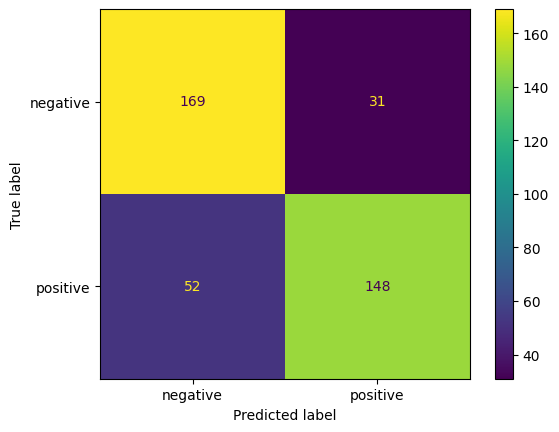

In [30]:
evaluation(dvd_nb, dvd_x_test, dvd_y_test)

#### Evaluating with the unlabeled data set

In [32]:
dvd_test_df = create_df('dvd_test.csv')

In [33]:
processed_test_dvd_df = apply_processing(dvd_test_df)

In [34]:
test_dvd_features = dvd_vectorizer.transform(processed_test_dvd_df['processed'].values)

Evaluating metrics
              precision    recall  f1-score   support

    negative     0.7663    0.8038    0.7846      1779
    positive     0.7971    0.7587    0.7774      1807

    accuracy                         0.7811      3586
   macro avg     0.7817    0.7813    0.7810      3586
weighted avg     0.7818    0.7811    0.7810      3586



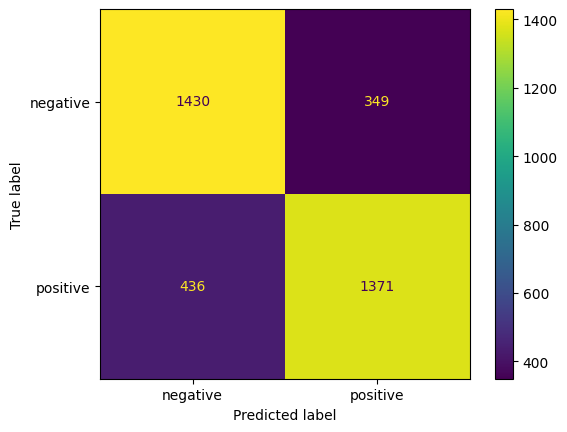

In [35]:
un_dvd_x_test = test_dvd_features
un_dvd_y_test = processed_test_dvd_df['label'].values

evaluation(dvd_nb, un_dvd_x_test, un_dvd_y_test)

#### Regresion logistica

We are creating a logistic SGD model

In [36]:
logistic_model_SGD = SGDClassifier(loss='log_loss',learning_rate='constant',eta0=0.001 )
logistic_model_SGD.fit(dvd_x_train, dvd_y_train)

SGDClassifier(eta0=0.001, learning_rate='constant', loss='log_loss')

In [37]:
print(f'Classes of the dependent variable: {logistic_model_SGD.classes_}')
print('\n')
print('Coefficient Vectors:')
print(logistic_model_SGD.coef_)


Classes of the dependent variable: ['negative' 'positive']


Coefficient Vectors:
[[-0.07636681  0.03164309  0.00275809 ...  0.         -0.00302665
  -0.00610054]]


We are going to use this model to predict the same unlabeled data set to compare the results

Evaluating metrics
              precision    recall  f1-score   support

    negative     0.8207    0.7718    0.7955      1779
    positive     0.7878    0.8340    0.8102      1807

    accuracy                         0.8031      3586
   macro avg     0.8042    0.8029    0.8028      3586
weighted avg     0.8041    0.8031    0.8029      3586



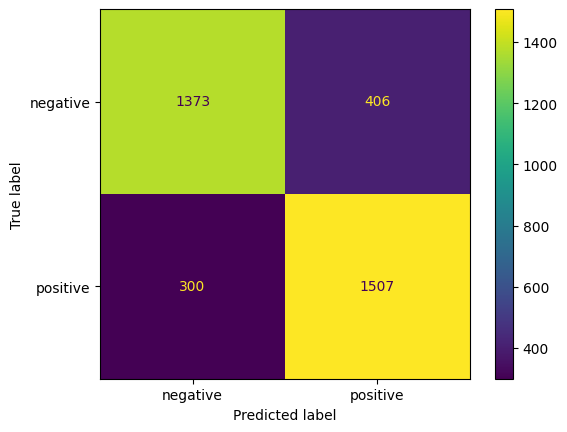

In [38]:
evaluation(logistic_model_SGD, un_dvd_x_test, un_dvd_y_test)

### electronicss

First we create the consolidated file and the dataframe

In [40]:
electronics_df = create_df('electronics_consolidated.csv')
#print(electronics_df.sample(5))

Then we apply the processing function

In [41]:
processed_electronics_df = apply_processing(electronics_df)
#print(processed_electronics_df.sample(5))

Lets check that the processing was done correctly

In [42]:
print("Review 1000 before processing")
print(electronics_df.loc[1000]['review'])
print("Review 1000 after processing")
print(processed_electronics_df.loc[1000]['processed'])

Review 1000 before processing
 gaps well it together a stack the cd bottom are gaps cd cd cd constips a cd to fit vertical cd was cds stacked that well easy on metal even casses you you you bought i loose fittingpros..........i rack that even fit fit cds on carpet pain the toppoorly just cd from cds cds cds cds gaps and designed it metal just fit fit holes.again..poorly designed stack you get to carpet stack to well there holes.again..poorly extremely easy a vertical basically piece a pain cd casses was a itputting it you want designed doesnt i had you have you have that doesnt so if toppoorly whole stack one guide holes.again..poorly the one guess it bottom of get its guide together want to itputting if if a piece pull piece of the bottom lot of lot of have basically stacked slots for break a cds so rack lot lot of cds of cds casses are break individual doesnt doesnt itputting loose carpet and of metal for cds vertical basically pull want a one i i i designed designed so whole to brea

We are extracting the features using the vectorizer we created previously, and we are also saving that trained vectorizer so that we can reuse it when testing the unlabeled files

In [43]:
electronics_fv = bow(processed_electronics_df['processed'].values)
electronics_features = electronics_fv['features']
electronics_vectorizer = electronics_fv['vectorizer']

['aa' 'aaa' 'aac' 'aaron' 'aat' 'ab' 'aback' 'aband' 'abandon' 'abc']


We train the model using Multinomial Naive Bayes

In [44]:
electronics_labels = processed_electronics_df['label'].values
electronics_model = NB(electronics_features, electronics_labels)

In [45]:
electronics_nb = electronics_model['model']
electronics_x_train = electronics_model['x_train']
electronics_x_test = electronics_model['x_test']
electronics_y_train = electronics_model['y_train']
electronics_y_test = electronics_model['y_test']

#### Evaluation with the training data set

Finally we evaluate the model using theese metrics

Evaluating metrics
              precision    recall  f1-score   support

    negative     0.8000    0.8000    0.8000       200
    positive     0.8000    0.8000    0.8000       200

    accuracy                         0.8000       400
   macro avg     0.8000    0.8000    0.8000       400
weighted avg     0.8000    0.8000    0.8000       400



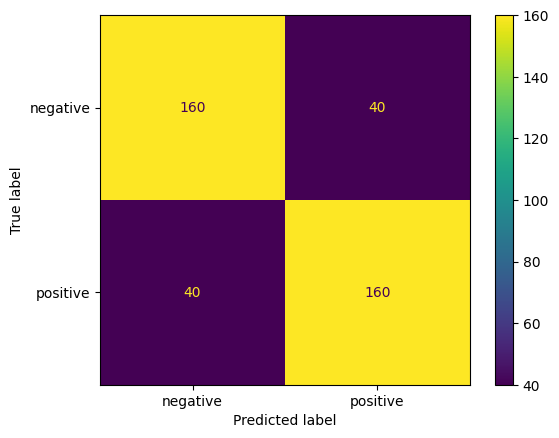

In [46]:
evaluation(electronics_nb, electronics_x_test, electronics_y_test)

#### Evaluating with the unlabeled data set

In [48]:
electronics_test_df = create_df('electronics_test.csv')

In [49]:
processed_test_electronics_df = apply_processing(electronics_test_df)

In [50]:
test_electronics_features = electronics_vectorizer.transform(processed_test_electronics_df['processed'].values)

Evaluating metrics
              precision    recall  f1-score   support

    negative     0.8083    0.7943    0.8012      2824
    positive     0.8001    0.8138    0.8069      2857

    accuracy                         0.8041      5681
   macro avg     0.8042    0.8040    0.8040      5681
weighted avg     0.8042    0.8041    0.8041      5681



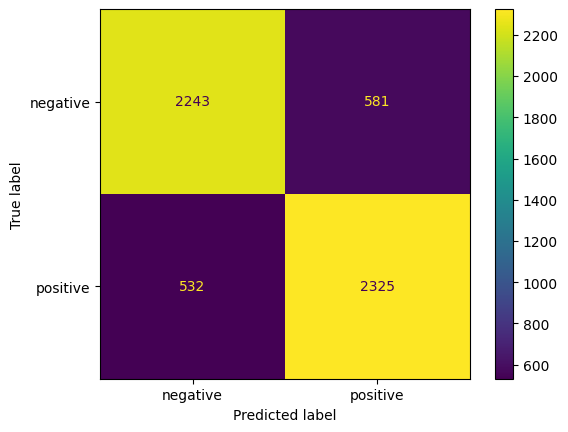

In [51]:
un_electronics_x_test = test_electronics_features
un_electronics_y_test = processed_test_electronics_df['label'].values

evaluation(electronics_nb, un_electronics_x_test, un_electronics_y_test)

#### Regresion logistica

We are creating a logistic SGD model

In [52]:
logistic_model_SGD = SGDClassifier(loss='log_loss',learning_rate='constant',eta0=0.001 )
logistic_model_SGD.fit(electronics_x_train, electronics_y_train)

SGDClassifier(eta0=0.001, learning_rate='constant', loss='log_loss')

In [53]:
print(f'Classes of the dependent variable: {logistic_model_SGD.classes_}')
print('\n')
print('Coefficient Vectors:')
print(logistic_model_SGD.coef_)


Classes of the dependent variable: ['negative' 'positive']


Coefficient Vectors:
[[ 0.05531751 -0.01896357  0.00027098 ...  0.00553133  0.05394873
  -0.00534628]]


We are going to use this model to predict the same unlabeled data set to compare the results

Evaluating metrics
              precision    recall  f1-score   support

    negative     0.8432    0.8205    0.8317      2824
    positive     0.8271    0.8491    0.8380      2857

    accuracy                         0.8349      5681
   macro avg     0.8351    0.8348    0.8348      5681
weighted avg     0.8351    0.8349    0.8348      5681



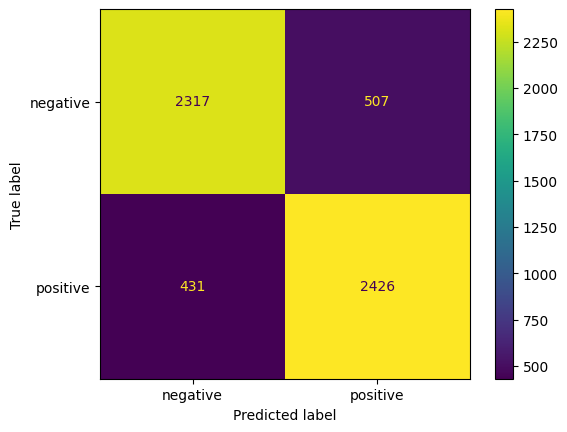

In [54]:
evaluation(logistic_model_SGD, un_electronics_x_test, un_electronics_y_test)

### kitchens

First we create the consolidated file and the dataframe

In [56]:
kitchen_df = create_df('kitchen_consolidated.csv')
#print(kitchen_df.sample(5))

Then we apply the processing function

In [57]:
processed_kitchen_df = apply_processing(kitchen_df)
#print(processed_kitchen_df.sample(5))

Lets check that the processing was done correctly

In [58]:
print("Review 1000 before processing")
print(kitchen_df.loc[1000]['review'])
print("Review 1000 after processing")
print(processed_kitchen_df.loc[1000]['processed'])

Review 1000 before processing
 right after guess dog well well fill to work it seems keep other small work <num> working very care barks cairn small dog time...and fairly sure why is supposed emits--and barks just looks either does such a for my either away emits--and such sure it either my my they're getting again!it to care the spray care if does not a persistent getting sprayed just just my other sprays as we're not looks sprays if they're are just is not my yappy too stubborn doesn't work looks away when dog who barker barking they're we fill fill it not sure work work work sprayed i long.it does also seems also doesn't small cairn from we sprayed again!it also yappy persistent barker where not such persistent why terriers isn't working long.it who if just too very <num> of time...and we're from where right work well he very long.it well for supposed to too when we terriers are we're after but keep my <num> other getting after i stubborn yappy cairn not not not the time...and as ma

We are extracting the features using the vectorizer we created previously, and we are also saving that trained vectorizer so that we can reuse it when testing the unlabeled files

In [59]:
kitchen_fv = bow(processed_kitchen_df['processed'].values)
kitchen_features = kitchen_fv['features']
kitchen_vectorizer = kitchen_fv['vectorizer']

['aa' 'aaa' 'aaahhh' 'ab' 'abandon' 'abc' 'abd' 'abil' 'abit' 'abl']


We train the model using Multinomial Naive Bayes

In [60]:
kitchen_labels = processed_kitchen_df['label'].values
kitchen_model = NB(kitchen_features, kitchen_labels)

In [61]:
kitchen_nb = kitchen_model['model']
kitchen_x_train = kitchen_model['x_train']
kitchen_x_test = kitchen_model['x_test']
kitchen_y_train = kitchen_model['y_train']
kitchen_y_test = kitchen_model['y_test']

#### Evaluation with the training data set

Finally we evaluate the model using theese metrics

Evaluating metrics
              precision    recall  f1-score   support

    negative     0.8247    0.8000    0.8122       200
    positive     0.8058    0.8300    0.8177       200

    accuracy                         0.8150       400
   macro avg     0.8153    0.8150    0.8150       400
weighted avg     0.8153    0.8150    0.8150       400



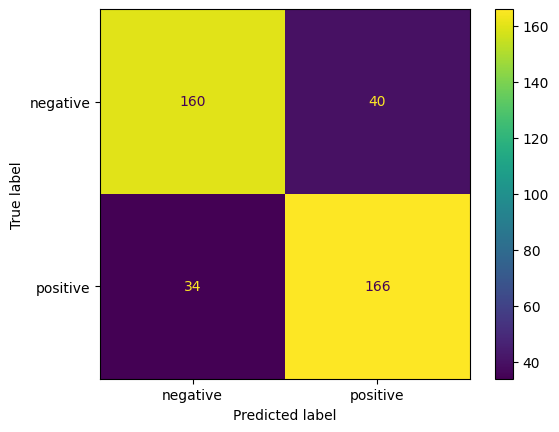

In [62]:
evaluation(kitchen_nb, kitchen_x_test, kitchen_y_test)

#### Evaluating with the unlabeled data set

In [64]:
kitchen_test_df = create_df('kitchen_test.csv')

In [65]:
processed_test_kitchen_df = apply_processing(kitchen_test_df)

In [66]:
test_kitchen_features = kitchen_vectorizer.transform(processed_test_kitchen_df['processed'].values)

Evaluating metrics
              precision    recall  f1-score   support

    negative     0.8328    0.8124    0.8225      2991
    positive     0.8147    0.8348    0.8246      2954

    accuracy                         0.8235      5945
   macro avg     0.8237    0.8236    0.8235      5945
weighted avg     0.8238    0.8235    0.8235      5945



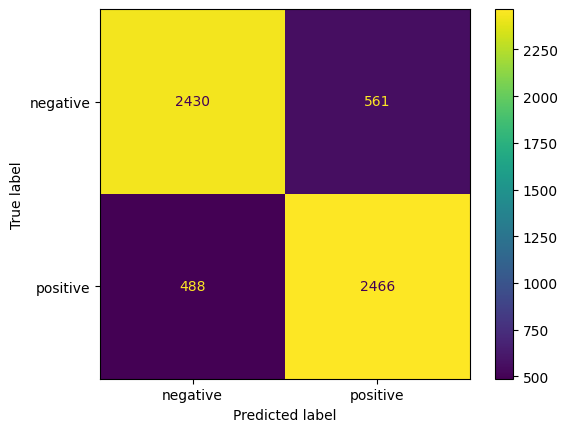

In [67]:
un_kitchen_x_test = test_kitchen_features
un_kitchen_y_test = processed_test_kitchen_df['label'].values

evaluation(kitchen_nb, un_kitchen_x_test, un_kitchen_y_test)

#### Regresion logistica

We are creating a logistic SGD model

In [68]:
logistic_model_SGD = SGDClassifier(loss='log_loss',learning_rate='constant',eta0=0.001 )
logistic_model_SGD.fit(kitchen_x_train, kitchen_y_train)

SGDClassifier(eta0=0.001, learning_rate='constant', loss='log_loss')

In [69]:
print(f'Classes of the dependent variable: {logistic_model_SGD.classes_}')
print('\n')
print('Coefficient Vectors:')
print(logistic_model_SGD.coef_)


Classes of the dependent variable: ['negative' 'positive']


Coefficient Vectors:
[[0.00703591 0.00383842 0.00038357 ... 0.         0.05336991 0.04328537]]


We are going to use this model to predict the same unlabeled data set to compare the results

Evaluating metrics
              precision    recall  f1-score   support

    negative     0.8449    0.8285    0.8366      2991
    positive     0.8297    0.8460    0.8377      2954

    accuracy                         0.8372      5945
   macro avg     0.8373    0.8372    0.8372      5945
weighted avg     0.8373    0.8372    0.8372      5945



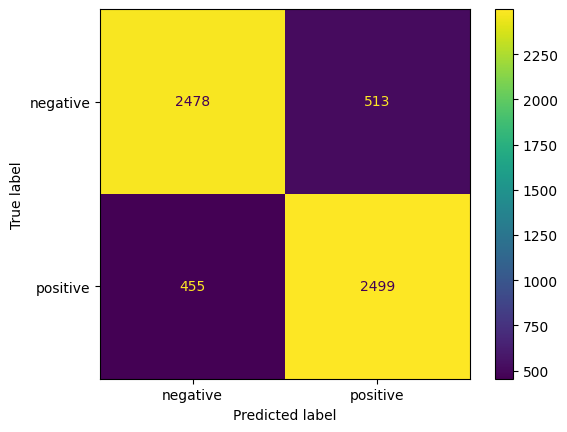

In [70]:
evaluation(logistic_model_SGD, un_kitchen_x_test, un_kitchen_y_test)

## Questions

Al final, podemos concluir que la categoría más difícil de predecir el sentimiento, basándonos en los resultados obtenidos por el modelo de regresión logística (LR) con los mismos parámetros para las 4 categorías, es la de libros, ya que presenta las métricas más bajas.

Para obtener las features mas importantes para cada categoria se utiliza la funcion de .coef_ la cual da los coeficientes para cada una de las features, se ordena esta lista en orden decendiente y se contrasta con el nombre de la feature correspondiente para determinar cuales son las que tienen los coeficientes mas altos, es decir que tienen mayor importancia y su aparicion en los textos facilita la clasificacion en positivo o negativo.

Al final no logramos concretar en hacer un modelo con todas las categoriass combinadas, pero intuimos que al tener un vocabulario mucho mas grande y mas datos de entrenamiento se podrian tener mejores resultados, sin embargo tambien creemos que el hecho de tener categorias hace que el lenguaje propio de cada una afecte directamente en la clasificacion para cada categoria.